# Udacity Self-Driving Car Engineer Nanodegree Program


### Import Statements

In [1]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import glob
from utils import *

%matplotlib inline

### Load Training Data

In [2]:
car_images = glob.glob('../training_vehicle_detection/vehicles/**/*.png')
noncar_images = glob.glob('../training_vehicle_detection/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


### Visualize Some of the Data

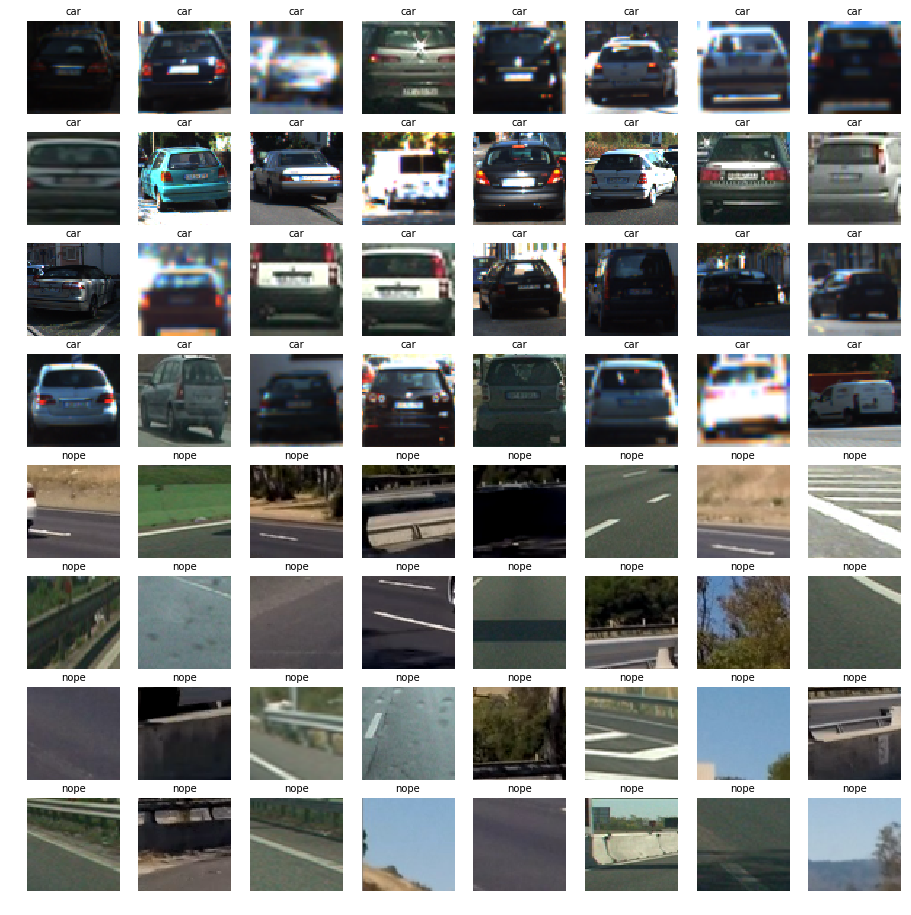

In [3]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope', fontsize=10)
    axs[i].imshow(img)

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook and in lines #8 through #34 of the file called `utils.py`).  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:
    

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `RGB` color space `G` channel and HOG parameters of `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


Text(0.5,1,'Non-Car HOG')

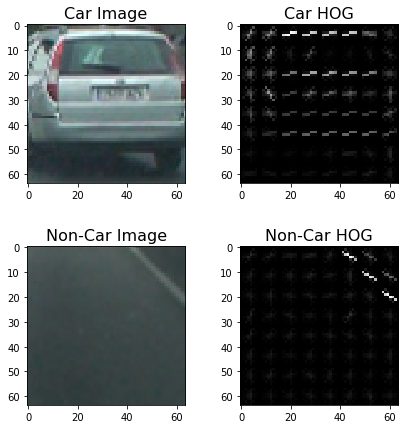

In [4]:
car_img = mpimg.imread(car_images[5])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8,viz=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, viz=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

### Extract Features for Input Datasets and Combine, Define Labels Vector, Shuffle and Split

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and I got good result with `YUV` color space and `orientation = 11, pix_per_block = 16, cell_per_block = 2`

In [5]:
# Feature extraction parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

car_features = extract_features(car_images,  orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
notcar_features = extract_features(noncar_images, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292


#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using LinearSVC, the accuracy is:

In [6]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

Test Accuracy of SVC =  0.9806
My SVC predicts:  [0. 0. 0. 0. 1. 1. 1. 1. 0. 1.]
For these 10 labels:  [0. 0. 0. 0. 1. 1. 1. 1. 0. 1.]


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search fixed windows in the image where there is a big chance goona have a vehicle (lower half of the image, different scale of ROI size.)
Following image is a plot of the ROIs (totally 328 boxes)

Number of boxes:  328


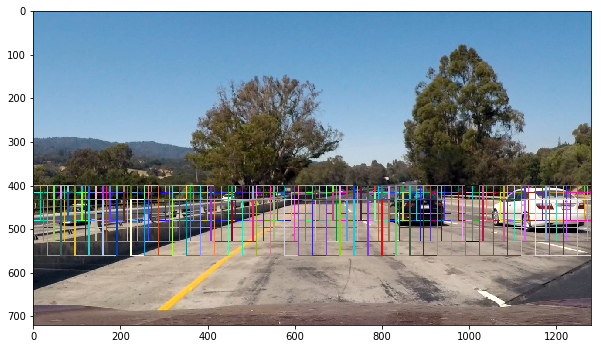

In [7]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

#orient = 11
#pix_per_cell = 16
#cell_per_block = 2

search_areas_list =[ [400 ,464 ,1.0], [416 ,480 ,1.0], [400 ,496 ,1.5], [432 ,528 ,1.5], [400 ,528 ,2.0], [432 ,560 ,2.0], [400 ,596 ,3.5], [464 ,660 ,3.5] ]                
for search_area in search_areas_list:
    rects.append(find_cars(test_img, *search_area, svc, orient, pix_per_cell, cell_per_block,show_all_rectangles=True))
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on 3 scales using HSV 3-channel HOG features. The function is between line # 36 and # 88 in `utils.py`, which provided a nice result: 

In [8]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5

rectangles = find_cars(test_img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block)

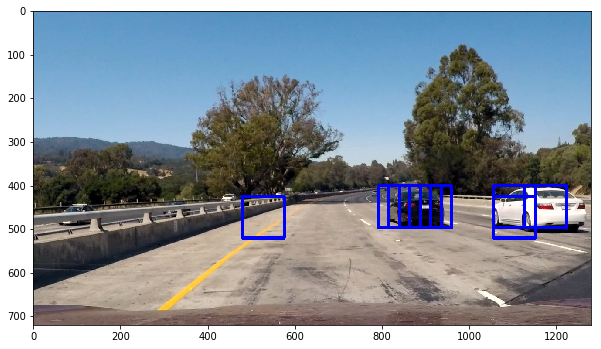

In [9]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)


### Combine Various Sliding Window Searches

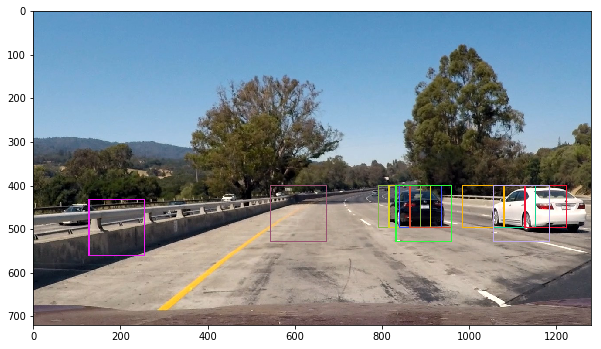

In [10]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []


search_areas_list =[ [400 ,464 ,1.0], [416 ,480 ,1.0], [400 ,496 ,1.5], [432 ,528 ,1.5], [400 ,528 ,2.0], [432 ,560 ,2.0], [400 ,596 ,3.5], [464 ,660 ,3.5] ]                
for search_area in search_areas_list:
    rects.append(find_cars(test_img, *search_area, svc, orient, pix_per_cell, cell_per_block))
# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

test_img = mpimg.imread('./test_images/test1.jpg')




*Exploration findings:* 
- A scale of less than 1.0 seemed to produce a lot of false positives. 
- The start and stop positions and scales used may need some tweaking in the future, depending on video performance.

### Heatmap

After getting those bounding boxes, I used heat map to get the finally bounding boxes. The code is between line #107 and #140 in `utils.py`

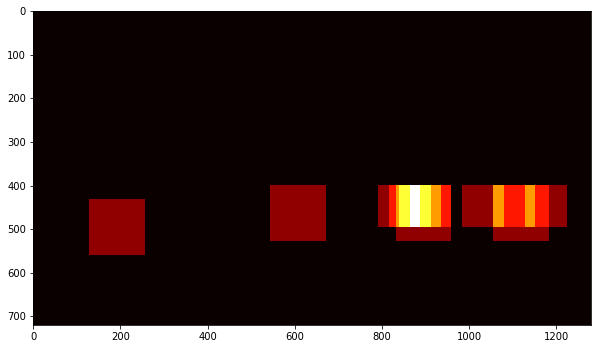

In [11]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')


#### Apply a Threshold to the Heatmap

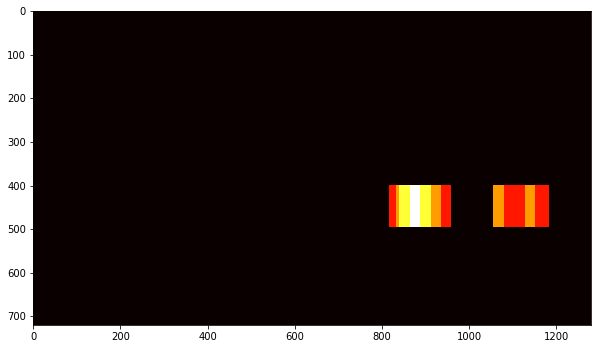

In [12]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')


#### Apply SciPy Labels to Heatmap

2 cars found


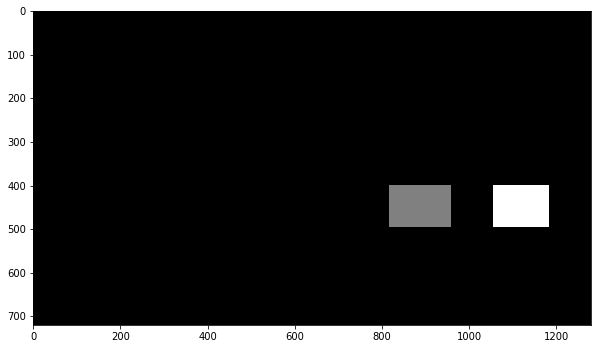

In [13]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

#### Draw Bounding Boxes for Lables

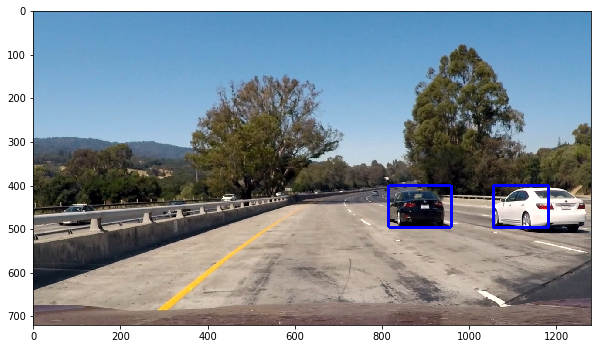

In [14]:
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

#### Put it All Together

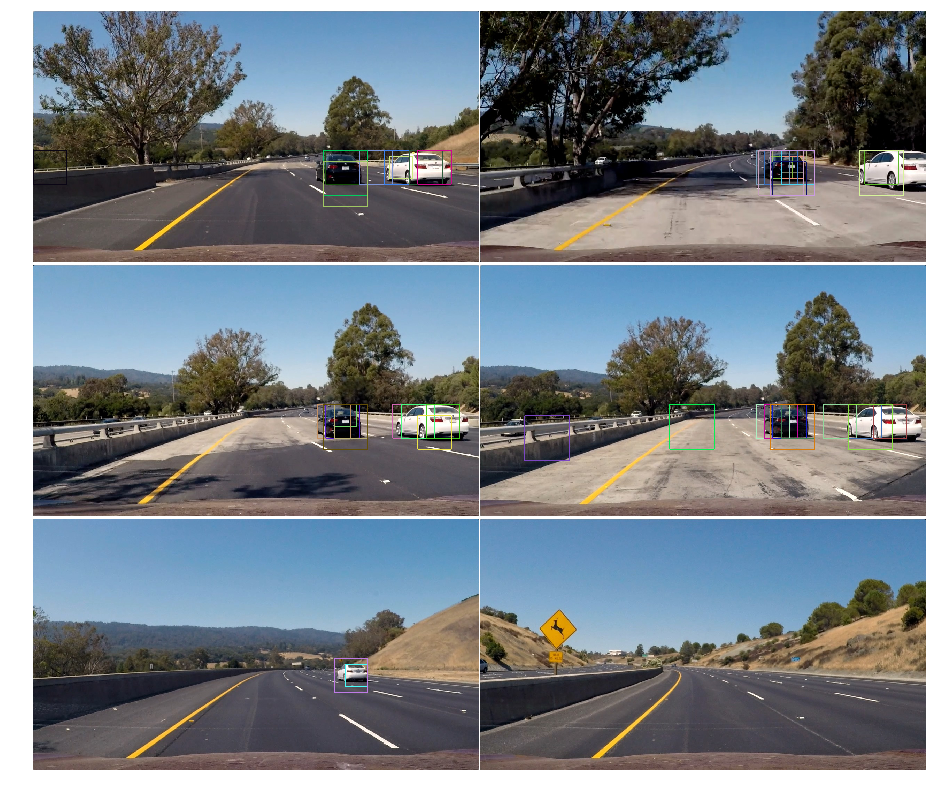

In [15]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()


search_areas_list =[ [400 ,464 ,1.0], [416 ,480 ,1.0], [400 ,496 ,1.5], [432 ,528 ,1.5], [400 ,528 ,2.0], [432 ,560 ,2.0], [400 ,596 ,3.5], [464 ,660 ,3.5] ] 
for i, im in enumerate(test_images):
    rects = []
    image = mpimg.imread(im)
    for search_area in search_areas_list:
        rects.append(find_cars(image, *search_area, svc, orient, pix_per_cell, cell_per_block))
        # apparently this is the best way to flatten a list of lists
        rectangles = [item for sublist in rects for item in sublist] 
        test_img_rects = draw_boxes(image, rectangles, color='random', thick=2)
    axs[i].imshow(test_img_rects)
    axs[i].axis('off')


### Run a Video Through the Pipeline 


In [16]:
det = Vehicle_Detect(svc,orient,pix_per_cell,cell_per_block)

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(det.process_frame)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [08:05<00:00,  2.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 8min 6s, sys: 29.8 s, total: 8min 36s
Wall time: 8min 6s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took. I used an svc trained a classifier on HOG feature. Detected cars with sliding window on interested region. After detection done, use heatmap to get the final bounding box for each vehicle.

what worked and why?
    the detector will work on vehicle back side images, because the most of the training data are tail of a vehicle. 

where the pipeline might fail?
    1. it might fail with bigger vehicles: such as truck, van, there not too much data of bigger vehicles in the training set. 
    2. it might fail when two car are overlapped in the image. Because it's not visiable to the camera, or it will be filtered as one object by the heat map method.
    
How I can improve it?
    first, I would like to use a tracker for each object, correlation filter is a good candidate of doing that work in my mind. 